Berceley Deep RL course. Fall 2017
http://rll.berkeley.edu/deeprlcourse/
Homework 1

## Section 4.  DAgger
1.  Implement DAgger.  See the code provided in
run
expert.py
to see how to query the expert policy
and perform roll-outs in the environment.
2.  Run DAgger and report results on one task in which DAgger can learn a better policy than behavioral
cloning.  Report your results in the form of a learning curve, plotting the number of DAgger iterations
vs.  the policy’s mean return, with error bars to show the standard deviation.  Include the performance
of the expert policy and the behavioral cloning agent on the same plot.  In the caption, state which
task you used, and any details regarding network architecture, amount of data, etc.  (as in the previous
section).

In [1]:
import gym

import pickle
import time
import math
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F

import matplotlib.pyplot as plt
%matplotlib inline



### Feed forward nn

In [2]:
class FFN(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3, output_size, dropout_rate = 0.3):
        super(FFN, self).__init__()
        self.dropout_rate = dropout_rate
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.drop1  = nn.Dropout(p = self.dropout_rate)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.drop2  = nn.Dropout(p = self.dropout_rate)
        self.fc3 = nn.Linear(hidden_size2, hidden_size2)
        self.drop3  = nn.Dropout(p = self.dropout_rate)
        self.fc4 = nn.Linear(hidden_size3, output_size)

    def forward(self, x):
        x = F.sigmoid(self.fc1(x))
        x = self.drop1(x)
        x = F.relu(self.fc2(x))
        x = self.drop2(x)
        x = F.relu(self.fc3(x))
        x = self.drop3(x)
        x = self.fc4(x)
        return x.view(x.size(0), -1)
    
    def set_dropout_rate(self, p):
        self.dropout_rate = p
        


In [3]:
criterion = torch.nn.L1Loss()

# Training function
def train_ffn(states_tensor, actions_tensor,learning_rate):
    tmp_loss = 0
    
    ffn.zero_grad()

    output = ffn(states_tensor)               # Predict action
    loss = criterion(output, actions_tensor)  # Calculate error
    tmp_loss += loss.data[0]
    loss.backward()                              # Error backpropagation

    for p in ffn.parameters():                   # Update net's parameters
        p.data.add_(-learning_rate, p.grad.data)
    
    return output, tmp_loss 

In [4]:
def get_expert_data(args,policy_fn):
    with tf.Session():
        tf_util.initialize()

        env = gym.make(args.envname)
        max_steps = args.max_timesteps or env.spec.timestep_limit

        returns = []
        observations = []
        actions = []
        for i in range(args.num_rollouts):
#             print('iter', i)
            obs = env.reset()
            done = False
            totalr = 0.
            steps = 0
            while not done:
                action = policy_fn(obs[None,:])
                observations.append(obs)
                actions.append(action)
                obs, r, done, _ = env.step(action)
                totalr += r
                steps += 1
                if args.render:
                    env.render()
                #if steps % 100 == 0: print("%i/%i"%(steps, max_steps))
                if steps >= max_steps:
                    break
            returns.append(totalr)

#         print('returns', returns)
#         print('mean return', np.mean(returns))
#         print('std of return', np.std(returns))

        expert_data = {'observations': np.array(observations),
                       'actions': np.array(actions)}
    
    return expert_data, returns

def get_expert_actions(policy_fn,observations):
    return policy_fn(np.array(observations))


#Evaluate learned policy
def run_agent(ffn, args):
    dropout_rate = ffn.dropout_rate
    ffn.dropout_rate = 0
    env = gym.make(args.envname)
    max_steps = args.max_timesteps or env.spec.timestep_limit

    returns = []
    observations = []
    actions = []
    for i in range(args.num_rollouts):
        #print('iter', i)
        obs = env.reset()
        done = False
        totalr = 0.
        steps = 0
        while not done:
            action = ffn(Variable(torch.Tensor(obs))).data.numpy()  
            observations.append(obs)
            actions.append(action)
            obs, r, done, _ = env.step(action)
            totalr += r
            steps += 1

            if args.render:
                env.render()

            if steps >= max_steps:
                break
            
        #print(totalr)
        returns.append(totalr)

    data = {'observations': np.array(observations),
            'actions': np.array(actions)}
    ffn.dropout_rate = dropout_rate
    return data,returns


In [11]:
import pickle
import tensorflow as tf
import numpy as np
import tf_util
import gym
import load_policy
import pandas as pd

tf.logging.set_verbosity(tf.logging.ERROR)

def train_DAgger(ffn, args):
    
    minibatch_size = args.get('minibatch_size',16)
    train_size = args.get('train_size',50000)

#     print('loading and building expert policy')
    target_policy_fn = load_policy.load_policy(args.expert_policy_file)
#     print('loaded and built')
    
    with tf.Session():
        tf_util.initialize()

        # Get initial data    
        get_expert_data_args = args.copy()
        get_expert_data_args.num_rollouts = 10
        expert_data, expert_returns = get_expert_data(get_expert_data_args, target_policy_fn) 
        train_data = expert_data
        train_data['actions'] = train_data['actions'][:,0,:]
#         print('init',train_data['actions'].shape)
        env = gym.make(args.envname)
        max_steps = args.max_timesteps or env.spec.timestep_limit

        returns = []
        errors = []
#         observations = []
#         actions = []
        agent_args = args.copy()
        agent_args.num_rollouts = 3
        
        for i in range(args.num_rollouts):
            
            # Train on expert_data
            error = 0
            print('train_size',len(train_data['observations']))
            for _ in range(int(len(train_data['observations']) / minibatch_size) + 1):
                idx = np.random.choice(len(train_data['observations']),minibatch_size)
                _, err = train_ffn(Variable(torch.Tensor(train_data['observations'][idx])), 
                                         Variable(torch.Tensor(np.array(train_data['actions'][idx]))),
                                         learning_rate
                                        )
                error += err
            error /= len(train_data['observations'])
            errors.append(error)
            
            # Get agent tragectory
            agent_data, rollout_returns = run_agent(ffn, agent_args)
            returns = returns + rollout_returns
            
            #Get expert actions for agent trajectory observations and add it to train data
            expert_actions = get_expert_actions(target_policy_fn,agent_data['observations'])
            train_data['observations'] = np.concatenate((train_data['observations'],agent_data['observations']))
            train_data['actions'] = np.concatenate((train_data['actions'], expert_actions))
            print(args.envname, i, np.mean(rollout_returns),error)
    return returns,errors,expert_returns            
            
 

### Train loop

In [24]:
learning_rate = 1e-5

#environments = 'Ant-v1 HalfCheetah-v1 Hopper-v1 Humanoid-v1 Reacher-v1 Walker2d-v1'.split(' ')
environments = 'HalfCheetah-v1'.split(' ')
warm_start = True

if not warm_start:
    results = {}
for envname in environments:
    env = gym.make(envname)
    state_shape = env.observation_space.shape[0]
    actions_shape = env.action_space.shape[0]

    print('Starting {} environment. State space dim {}, action space dim {}.'.format(
        envname,
        state_shape,
        actions_shape)
         )

    if warm_start:
        ffn = results[envname]['agent']
    else:
        ffn = FFN(state_shape, 128, 128, 128,actions_shape,dropout_rate = 0)

    args = pd.Series({
            'expert_policy_file':'experts/' + envname + '.pkl',
            'envname': envname,
            'max_timesteps': None,
            'num_rollouts':30,
            'render': False
        })

    returns,errors,expert_returns = train_DAgger(ffn, args)
    
    print('''Environment {}. State space dim {}, action space dim {}.
        DAgger run on {} rollouts.
        Mean reward {:.3f}. Reward std {:.3f}.
        '''.format(
        envname,
        state_shape,
        actions_shape,
        args.num_rollouts,
        np.mean(returns[-20:]),
        np.std(returns[-20:])
    ))
    results[envname] = {'returns':returns,'errors':errors,'expert_returns':expert_returns, 'agent':ffn}
pickle.dump(results,open('DAgger_results.pck','wb'))


[2017-11-06 19:48:55,298] Making new env: HalfCheetah-v1
[2017-11-06 19:48:55,521] Making new env: HalfCheetah-v1


Starting HalfCheetah-v1 environment. State space dim 17, action space dim 6.
obs (1, 17) (1, 17)


[2017-11-06 19:49:02,470] Making new env: HalfCheetah-v1


train_size 10000


[2017-11-06 19:49:04,086] Making new env: HalfCheetah-v1


HalfCheetah-v1 0 4115.34472133 0.0033308995719999075
train_size 13000


[2017-11-06 19:49:08,980] Making new env: HalfCheetah-v1


HalfCheetah-v1 1 4070.64015 0.0033253934158442113
train_size 16000


[2017-11-06 19:49:14,275] Making new env: HalfCheetah-v1


HalfCheetah-v1 2 4089.5064685 0.0033313295057741926
train_size 19000


[2017-11-06 19:49:19,976] Making new env: HalfCheetah-v1


HalfCheetah-v1 3 3990.46715586 0.0033092214116140417
train_size 22000


[2017-11-06 19:49:26,057] Making new env: HalfCheetah-v1


HalfCheetah-v1 4 3979.24072894 0.003327109789814461
train_size 25000


[2017-11-06 19:49:32,478] Making new env: HalfCheetah-v1


HalfCheetah-v1 5 4134.38136559 0.003378672489821911
train_size 28000


[2017-11-06 19:49:40,496] Making new env: HalfCheetah-v1


HalfCheetah-v1 6 4061.16402322 0.0033562965886667372
train_size 31000


[2017-11-06 19:49:48,940] Making new env: HalfCheetah-v1


HalfCheetah-v1 7 4231.2499119 0.0033317635264247655
train_size 34000


[2017-11-06 19:49:57,715] Making new env: HalfCheetah-v1


HalfCheetah-v1 8 4110.34845339 0.003335520336185308
train_size 37000


[2017-11-06 19:50:08,204] Making new env: HalfCheetah-v1


HalfCheetah-v1 9 3955.54453554 0.003340806778218295
train_size 40000


[2017-11-06 19:50:16,923] Making new env: HalfCheetah-v1


HalfCheetah-v1 10 4063.03683281 0.003368410898372531
train_size 43000


[2017-11-06 19:50:25,628] Making new env: HalfCheetah-v1


HalfCheetah-v1 11 4158.31978633 0.003367854242191412
train_size 46000


[2017-11-06 19:50:36,453] Making new env: HalfCheetah-v1


HalfCheetah-v1 12 4049.71827635 0.003340949518241636
train_size 49000


[2017-11-06 19:50:47,258] Making new env: HalfCheetah-v1


HalfCheetah-v1 13 4154.35884112 0.0033559528750424484
train_size 52000


[2017-11-06 19:50:58,438] Making new env: HalfCheetah-v1


HalfCheetah-v1 14 4149.96826379 0.0033335469149124736
train_size 55000


[2017-11-06 19:51:09,304] Making new env: HalfCheetah-v1


HalfCheetah-v1 15 4017.99167646 0.0033385746706615796
train_size 58000


[2017-11-06 19:51:20,025] Making new env: HalfCheetah-v1


HalfCheetah-v1 16 3995.87069136 0.003347458471865233
train_size 61000


[2017-11-06 19:51:31,177] Making new env: HalfCheetah-v1


HalfCheetah-v1 17 4115.73908814 0.0033750129941179127
train_size 64000


[2017-11-06 19:51:42,735] Making new env: HalfCheetah-v1


HalfCheetah-v1 18 3991.097245 0.003343067754904041
train_size 67000


[2017-11-06 19:51:54,965] Making new env: HalfCheetah-v1


HalfCheetah-v1 19 4056.53371718 0.003352381817218083
train_size 70000


[2017-11-06 19:52:07,416] Making new env: HalfCheetah-v1


HalfCheetah-v1 20 4069.48702313 0.003351868522912264
train_size 73000


[2017-11-06 19:52:20,248] Making new env: HalfCheetah-v1


HalfCheetah-v1 21 4052.34492252 0.0033513625836739803
train_size 76000


[2017-11-06 19:52:33,610] Making new env: HalfCheetah-v1


HalfCheetah-v1 22 4037.06834436 0.003338775195892116
train_size 79000


[2017-11-06 19:52:47,177] Making new env: HalfCheetah-v1


HalfCheetah-v1 23 4065.8334143 0.0033462255626586796
train_size 82000


[2017-11-06 19:53:01,087] Making new env: HalfCheetah-v1


HalfCheetah-v1 24 4119.76887699 0.003346956284194276
train_size 85000


[2017-11-06 19:53:15,595] Making new env: HalfCheetah-v1


HalfCheetah-v1 25 3982.37849148 0.003339701595398433
train_size 88000


[2017-11-06 19:53:32,318] Making new env: HalfCheetah-v1


HalfCheetah-v1 26 4075.14591508 0.003347632488468662
train_size 91000


[2017-11-06 19:53:49,044] Making new env: HalfCheetah-v1


HalfCheetah-v1 27 4107.61769292 0.0033433202650234267
train_size 94000


[2017-11-06 19:54:07,159] Making new env: HalfCheetah-v1


HalfCheetah-v1 28 4070.11487259 0.0033385970960073965
train_size 97000


[2017-11-06 19:54:24,952] Making new env: HalfCheetah-v1


HalfCheetah-v1 29 4087.02040533 0.0033318613807373134
Environment HalfCheetah-v1. State space dim 17, action space dim 6.
        DAgger run on 30 rollouts.
        Mean reward 4069.258. Reward std 105.667.
        


In [21]:
for envname in environments:
    print('''Environment {}. State space dim {}, action space dim {}.
        DAgger run on {} rollouts.
        Mean reward {:.3f}. Reward std {:.3f}.
        Mean expert reward {:.3f}. Expert reward std {:.3f}.
        '''.format(
        envname,
        state_shape,
        actions_shape,
        args.num_rollouts,
        np.mean(results[envname]['returns'][-20:]),
        np.std(results[envname]['returns'][-20:]),
        np.mean(results[envname]['expert_returns'][-20:]),
        np.std(results[envname]['expert_returns'][-20:])

    ))
 

Environment HalfCheetah-v1. State space dim 17, action space dim 6.
        DAgger run on 20 rollouts.
        Mean reward 4042.186. Reward std 80.371.
        Mean expert reward 4163.384. Expert reward std 72.810.
        


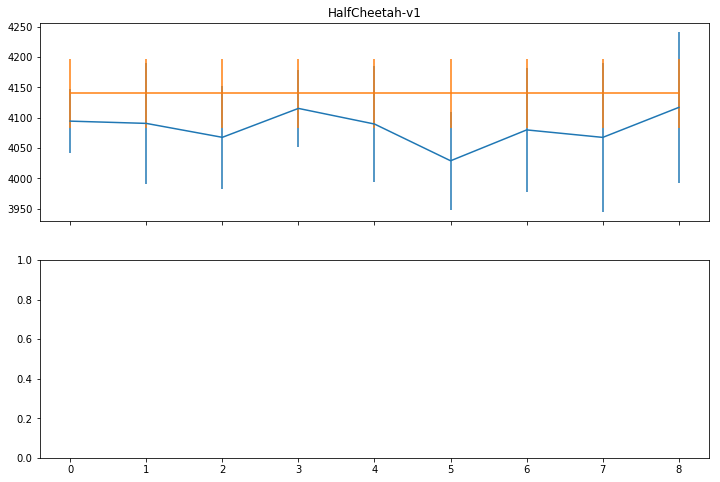

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline
fig, axs = plt.subplots(nrows=len(environments)+1, ncols=1, figsize = (12, 8*len(environments)), sharex=True)
#
for envname in environments:
    x = range(int(len(results[envname]['returns'])/10))
    y,yerr = [], []
    for i in x:
        y.append(  np.mean(results[envname]['returns'][i*10:(i+1)*10]))
        yerr.append(np.std(results[envname]['returns'][i*10:(i+1)*10]))
    ax = axs[environments.index(envname)]
    ax.errorbar(x, y, yerr=yerr, fmt='-')
    ax.errorbar(x,[np.mean(results[envname]['expert_returns'])]*len(x),[np.std(results[envname]['expert_returns'])]*len(x))
    ax.set_title(envname)
#     ax.text(0,10,'''Environment {}. State space dim {}, action space dim {}.
#         DAgger run on {} rollouts.
#         Mean reward {:.3f}. Reward std {:.3f}.
#         Mean expert reward {:.3f}. Expert reward std {:.3f}.
#         '''.format(
#         envname,
#         state_shape,
#         actions_shape,
#         args.num_rollouts,
#         np.mean(results[envname]['returns'][-20:]),
#         np.std(results[envname]['returns'][-20:]),
#         np.mean(results[envname]['expert_returns'][-20:]),
#         np.std(results[envname]['expert_returns'][-20:]))
#            )
    #ax.legend()


In [ ]:
fig.savefig('DAgger_results1.png')

In [ ]:

import matplotlib.pyplot as plt
%matplotlib inline

fig, ax1 = plt.subplots()
ax1.plot(returns, 'b-')
#ax1.set_xlabel('time (s)')
ax1.set_ylabel('error', color='b')
ax1.tick_params('y', colors='b')

ax2 = ax1.twinx()
ax2.plot(returns, 'g')
ax2.set_ylabel('reward', color='g')
ax2.tick_params('y', colors='g')

fig.tight_layout()
plt.show()
